# Task 2a: Active Learning for SAT Solving -- Demo


In this notebook, we demonstrate the use of `scikit-activeml`.
The [official tutorials](https://scikit-activeml.github.io/scikit-activeml-docs/tutorials.html) are a good starting point.

We start by loading the data and splitting it into features/target and train/test.
Also, we encode the class labels numerically to be compatible with `scikit-activeml`'s default label for unlabeled instances (`NaN`).
(Alternatively, we could set a different placeholder value when initializing the query strategies.)

In [1]:
import pandas as pd
import sklearn.model_selection
import sklearn.preprocessing

dataset = pd.read_csv('data/dataset.csv')
X = dataset[[x for x in dataset.columns if x.startswith('base.') or x.startswith('gate.')]]
y = pd.Series(sklearn.preprocessing.LabelEncoder().fit_transform(dataset['result']))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=25, stratify=y)

Next, we create our prediction model.
`scikit-activeml` provides a few models on its own but also allows to wrap `scikit-learn` models.
The wrapper is necessary to handle missing (default-value) class labels of unlabeled instances.

In [2]:
import skactiveml.classifier
import sklearn.tree

clf_model = skactiveml.classifier.SklearnClassifier(
    estimator=sklearn.tree.DecisionTreeClassifier(random_state=25),
    classes=y.unique(),
    random_state=25
)

The query strategy determines in which order the points are labeled.
`scikit-activeml` provides multiple such strategies; we compare two simple ones.

In [3]:
import skactiveml.pool

query_strategies = {
    'Random': skactiveml.pool.RandomSampling(random_state=25),
    'Uncertainty-Entropy': skactiveml.pool.UncertaintySampling(method='entropy', random_state=25)
}

We now run these two query strategies.
The batch size determines how many points are queried at once.
We evaluate prediction performance on the labeled part of the training set (but training-set evaluation is boring for decision trees anyway) and on the independent test set.

In [4]:
import warnings

import skactiveml.utils
import sklearn.metrics
import tqdm

BATCH_SIZE = 20
METRIC= sklearn.metrics.matthews_corrcoef

results = []
with warnings.catch_warnings():
    # Ignore warnings caused by the missing labels in the first iteration:
    warnings.filterwarnings(message='.*could not be fitted.*', action='ignore')
    for qs_name, qs_model in query_strategies.items():
        # Start with completely unlabeled data:
        y_train_al = pd.Series([skactiveml.utils.MISSING_LABEL] * len(y_train))
        labeled_idx = []
        for i in tqdm.tqdm(range(int(len(y_train) / BATCH_SIZE)), desc=qs_name):
            # The query strategy uses the prediction model unless for random sampling:
            if isinstance(qs_model, skactiveml.pool.RandomSampling):
                query_idx = qs_model.query(X=X_train, y=y_train_al, batch_size=BATCH_SIZE)
            else:
                query_idx = qs_model.query(X=X_train, y=y_train_al, clf=clf_model, batch_size=BATCH_SIZE)
            # Reveal the labels of queried instances (replace the default labels at these locations):
            y_train_al.iloc[query_idx] = y_train.iloc[query_idx]
            # Collect learning statistics for evaluation:
            labeled_idx.extend(query_idx)
            X_train_labeled = X_train.iloc[labeled_idx]
            y_train_labeled = y_train_al.iloc[labeled_idx]
            clf_model.fit(X=X_train_labeled, y=y_train_labeled)
            y_train_pred = clf_model.predict(X=X_train_labeled)
            train_score = METRIC(y_true=y_train_labeled, y_pred=y_train_pred)
            y_test_pred = clf_model.predict(X=X_test)
            test_score = METRIC(y_true=y_test, y_pred=y_test_pred)
            results.append({'query_strategy': qs_name, 'iteration': i,
                            'train_score': train_score, 'test_score': test_score})
results = pd.DataFrame(results)

Uncertainty-Entropy: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.43it/s]


Let's plot the learning curves:

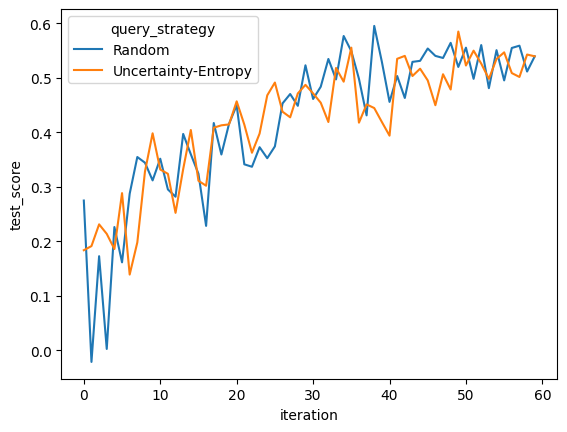

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=results, x='iteration', y='test_score', hue='query_strategy')
plt.show()